# Classical and quantum dynamics of electrons in open stadium billiards

In [1]:
import kwant
import scipy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
from scipy import signal as sig

# Latex like axis
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('xtick', labelsize=12) 
rc('ytick', labelsize=12)

C:\Users\leblanco.OASIS\Anaconda3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


### Fundamental constants

In [2]:
h = 6.626069e-34    # Planck constant (Js)
h_ = h/(2*np.pi)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)

### Geometry of the device

In [3]:
"Equilateral triangle"
def equitriangle (side):
    def geom(pos):
        x, y = pos
        m1 = -1/np.sqrt(3)
        p1 = side/2
        m2 = 1/np.sqrt(3)
        p2 = -side/2
        return (x>=0 and x<side*np.sqrt(3)/2 and y>m2*x+p2 and y<m1*x+p1)
    return geom

"Square"
def square(sidelength) :
    def geom(pos):
        x, y = pos
        return (x>=-sidelength/2 and x<sidelength/2 and y>=-sidelength/2 and y<sidelength/2)
    return geom

"Rectangle"
def rectangle(width, height):
    def geom(pos):
        x, y = pos
        return (x>=-width/2 and x<width/2 and y>=-height/2 and y<height/2)
    return geom
    
"Circle"
def circle (radius) :
    def geom(pos):
        x, y = pos
        return (x**2+y**2<radius**2)
    return geom

"Ring"
def ring(inner_radius, outer_radius):
    def geom(pos):
        x, y = pos
        r = np.sqrt(x**2 + y**2)
        return np.logical_and(inner_radius < r, r < outer_radius)
    return geom

    
"Stadium"
def stadium(length, radius):
    def geom(pos):
        x, y = pos
        return np.logical_or( np.logical_or((x-length/2)**2+y**2<(radius)**2, (x+length/2)**2+y**2<(radius)**2 ) , np.logical_and( np.abs(y)<radius, np.abs(x)<length/2) )
    return geom

def is_in_stadium(x, y, length, radius):
    return np.logical_or( np.logical_or((x-length/2)**2+y**2<(radius)**2, (x+length/2)**2+y**2<(radius)**2 ) , np.logical_and( np.abs(y)<radius, np.abs(x)<length/2) )

## Parameters of the experiment

### Scaling

In [4]:
asquare = 0.25e-9 # [m] a is the lattice parameter
tsquare = 2.8 # [eV] t is the hopping parameter
scaling = 1.0 # scaling factor
"""scaling"""
a = asquare * scaling
t = tsquare / scaling**2

### Fermi energy, velocity and wavelength

In [5]:
"Fermi energy"
Ef = 0.3106*t   # Chosen Fermi energy [eV]
m = h_**2/(2*a**2*t) # Effective mass
k_F = np.sqrt(2*m*Ef/(h_**2)) # Wavevector
v_F = np.sqrt(2*Ef/m) # Fermi velocity

print("k_F = ", k_F)
print("E_F = ", Ef, "eV")
print("vF = ", v_F)
print("m* = ", m)

k_F =  2229259966.8948436
E_F =  0.8696799999999999 eV
vF =  7.398653280636026e+24
m* =  3.1774895215452026e-50


### Verifying of the conditions

In [6]:
""" The wavelength must be (much more) larger than the lattice parameter """
lambda_F2 = 2 * np.pi * a * np.sqrt(t / Ef) 
print("\lambda_F = ", lambda_F2)
if lambda_F2/a < 2:
    print('Warning : lambda_F must be larger than the lattice parameter a')
    
""" The Fermi energy must be smaller than the hopping parameter t"""
print("E_F = ", Ef)
if Ef/t > 0.5:
    print('Warning : E_F must be smaller than the hopping parameter t')

\lambda_F =  2.8185072178600557e-09
E_F =  0.8696799999999999


### Geometry of the leads

In [7]:
def lead_upper(width_lead):
    def geom(pos):
        x, y = pos
        return -width_leads/2 < x < width_leads/2
    return geom

### Defining a smooth potential

In [8]:
def smooth_pot(site, effrad, radius, length, H):
    x, y = site.pos
    if ( abs(y) < radius and abs(x) < length/2 ):
        pot = H* (y**2 -effrad**2) / (radius**2-effrad**2)
    elif ( x > 0 ):
        pot = H* ( (x-length/2)**2+y**2 -effrad**2 ) / (radius**2-effrad**2)
    elif ( x < 0 ): 
        pot = H* ( (x+length/2)**2+y**2 -effrad**2 ) / (radius**2-effrad**2)
    if ( (x-length/2)**2+y**2<effrad**2 or (x+length/2)**2+y**2<(effrad)**2 or ( np.abs(y)<effrad and np.abs(x)<length/2) ):
        pot = 0
    return pot

### Placing all site in the bottom of the conduction band and adding the smooth potential

In [9]:
def onsite(site, Bfield, Vg):
    """
    Definition of the potential. To reach the bottom of the conduction band, the potential is set at 4*t.
    Then a smooth quadratic potential is added near the edges of the cavity.
    """
    (x, y) = site.pos
    return 4*t #+ smooth_pot(site, effrad, radius, length, H)

#### The hopping parameter

In [10]:
def hopping(site_i, site_j, Bfield, Vg):
    return t

## Building the system

2.2548057742880445e-08


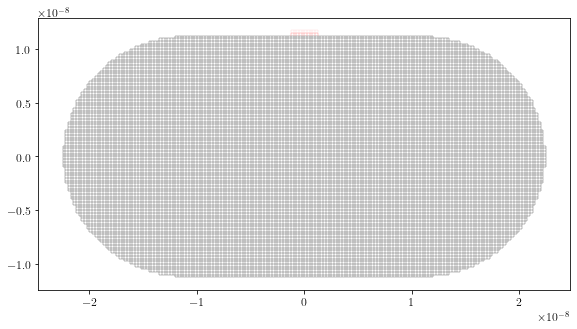

In [11]:
Bfield = 0 
Vg = 0
" Parameters " 
# lambda_F = lambda_F2*(4.75/6)
lambda_F = lambda_F2
radius = 4*lambda_F       # in [nm]
length = 2*radius    # distance between the two semicircles
print(length)
width_leads = lambda_F2
coeff = 0.6
effrad = coeff*radius
H = 0.1*t             # Potential height on the contour (in [eV])

def sys_builder(a):
    
    lat = kwant.lattice.square(a, norbs = 1) # norbs gives the number of orbitals per atom. It is needed to compute J

    sys = kwant.Builder() 
    
    sys[lat.shape(stadium(length, radius), (0,0))] = onsite 
    
    sys[lat.neighbors()] = hopping 

    """ Lead 1 """
    sym1 = kwant.TranslationalSymmetry(lat.vec((0, 1)))
    lead1 = kwant.Builder(sym1)
    lead1[lat.shape(lead_upper(width_leads), (0,0))] = 4*t 
    lead1[lat.neighbors()] = hopping
    """ The leads are attached """
    sys.attach_lead(lead1)

    sys = sys.finalized()
    
    return sys

"Building and plotting the system"
sys = sys_builder(a)
figure = kwant.plot(sys, site_size = 1e-9, fig_size = (10,5), lead_color = 'r')

### Computing the wave function and visualizing the pdf 
$P(\mathbf{r}) = |\Psi_n (\mathbf{r})|^2 $ 

In [12]:
import warnings
warnings.filterwarnings("ignore")

(2, 14587)


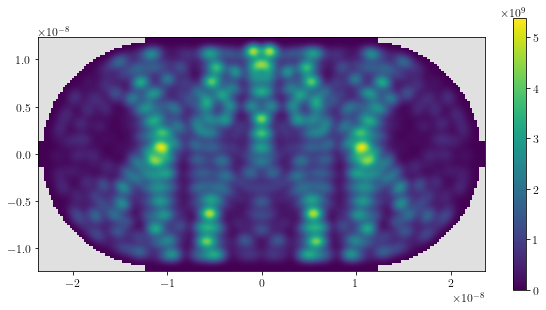

IndexError: index 2 is out of bounds for axis 0 with size 2

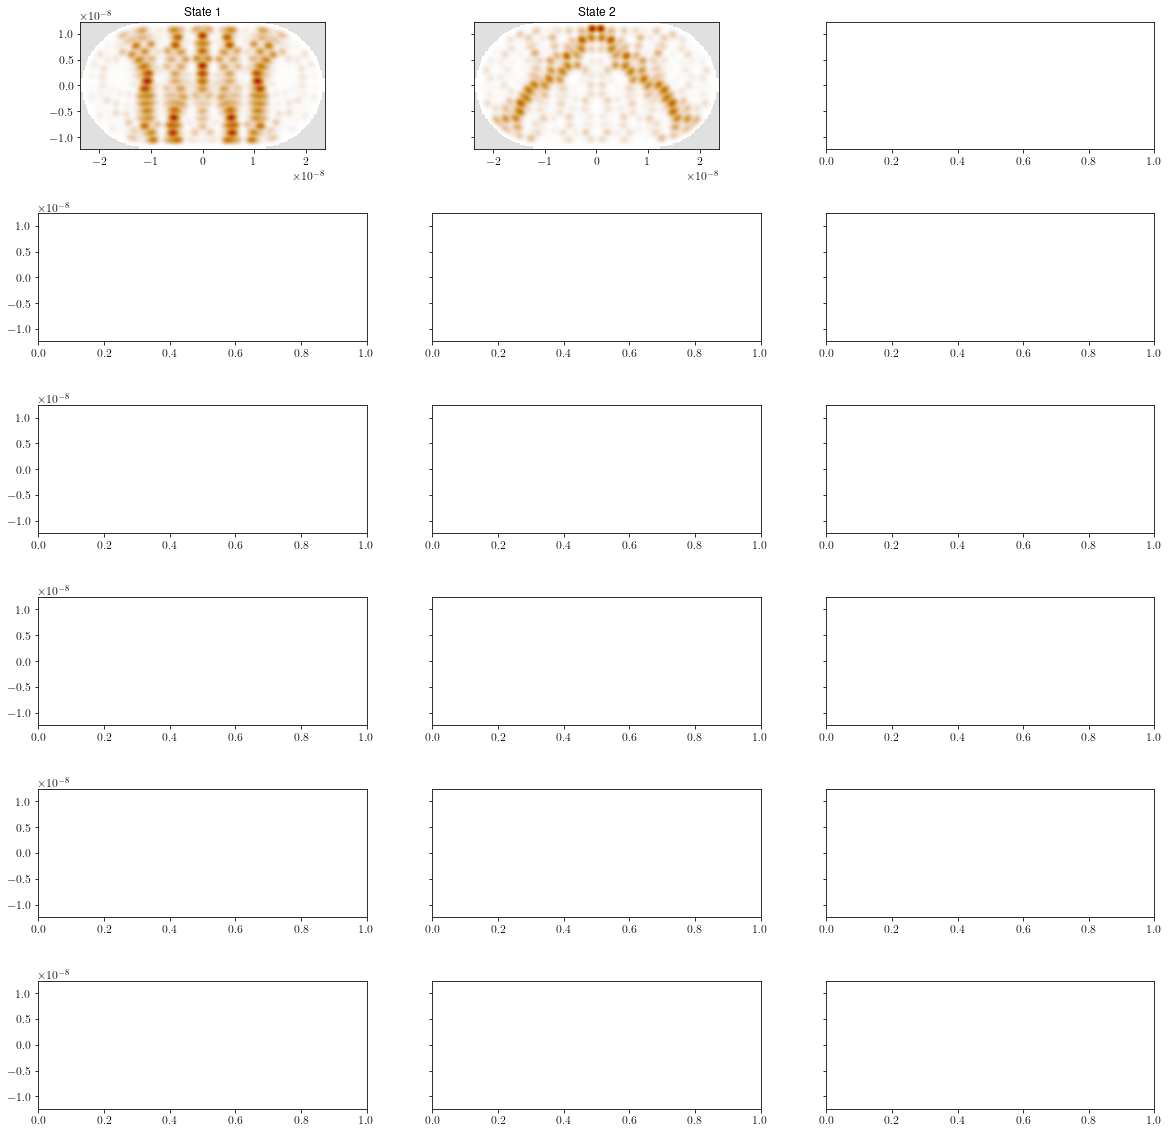

In [13]:
nmodes = 16

params = dict(r0=20, delta=10, J=0, Bfield = Bfield, Vg = Vg)
wfs = kwant.wave_function(sys, energy=Ef, params=params) 
scattering_wf = wfs(0)  
print(wfs(0).shape)
proba = sum(abs(scattering_wf)**2)
kwant.plotter.density(sys, proba, fig_size = (10,5), cmap='viridis')

# Plot the different eigenmodes
fig, axis = plt.subplots(int(np.ceil(nmodes/3)),3, sharey=True, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)
for i in np.arange(nmodes):
    a1 = int(i%3)
    b = int(np.floor(i/3))
    kwant.plotter.density(sys, abs(scattering_wf[i])**2, ax=axis[b][a1])
    axis[b][a1].set_title('State '+str(i+1)) 

### For different energy levels $E$

In [ ]:
E=0.3257894736842106*t
lambda_F3 = 2 * np.pi * a * np.sqrt(t / E)
print(lambda_F3/radius)
wfs = kwant.wave_function(sys, energy=E, params=dict(Bfield = Bfield, Vg=Vg)) 
scattering_wf = wfs(0)  
kwant.plotter.density(sys, sum(abs(scattering_wf)**2))

In [ ]:
n_subplots = 30
energies = np.linspace(0.30*t, 0.35*t, n_subplots)

fig, axis = plt.subplots(int(np.ceil(n_subplots/3)),3, sharey=True, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)
for i in np.arange(n_subplots):
    E = energies[i]
    a1 = int(i%3)
    b = int(np.floor(i/3))
    wfs = kwant.wave_function(sys, energy=E, params=dict(Bfield = Bfield, Vg=Vg)) 
    scattering_wf = wfs(0)  
    kwant.plotter.density(sys, sum(abs(scattering_wf)**2), ax=axis[b][a1])
    axis[b][a1].set_title('Ef/t '+str(E/t)) 

### Computing and plotting the Madelung transform
The objective is to build $\mathbf{v} (\mathbf{x}, t) = \frac{\mathbf{j}(\mathbf{x},t)}{|\Psi (\mathbf{x}, t)|^2}$ <br>
$\mathbf{j}(\mathbf{x},t)$ is obtained using **kwant.operator.Current** <br>
$|\Psi (\mathbf{x}, t)|^2$ is obtained using **kwant.wave_function** but must be extended to reach the length of the array containing the current components, whose length is the number of hoppings between the atoms inside the system

In [ ]:
J0 = kwant.operator.Current(sys)
current = sum(J0(p, params=dict(Bfield=Bfield, Vg=Vg)) for p in wfs(0)) # to sum over all the lead's mode
wfs = kwant.wave_function(sys, energy=Ef, params=dict(Bfield = Bfield, Vg=Vg))
proba = sum(abs(wfs(0))**2)

# Probabibilty extension
extended_proba = []
for i, elem in enumerate(proba) :
    x, y = sys.sites[i].pos
    count = 0
    vec = np.arange(2)+1
    count += sum(is_in_stadium(x+a*(-1)**vec, y, length, radius))
    count += sum(is_in_stadium(x, y+a*(-1)**vec, length, radius))
    val = np.array(elem)
    extended_proba = np.concatenate( (extended_proba, val.repeat(count, axis=0) ) )

kwant.plotter.current(sys, current/extended_proba, cmap='viridis')


### Observing recurences 

In [ ]:
# Reference scars pattern for the correlation
wfs = kwant.wave_function(sys, energy=0.2*t, params=dict(Bfield = Bfield, Vg=Vg))
scattering_wf = wfs(0)  
proba = sum(abs(scattering_wf)**2)
N = len(proba)
fft_ref = np.fft.fft(proba)
std_ref = np.sqrt( sum( (proba-np.mean(proba))**2))
width = proba.shape
kwant.plotter.map(sys, proba, fig_size = (10,5))
# kwant.plotter.map(sys, abs(scattering_wf[0])**2, fig_size = (10,5))

# Comparing the pattern with the ones for other energies
n_elem = 10
energies = np.linspace(0.2*t, 0.4*t, n_elem)
corrvals = np.zeros(n_elem)

for i in range(1, n_elem):
    E = energies[i]
    wfs = kwant.wave_function(sys, energy=E, params=dict(Bfield = Bfield, Vg=Vg)) # the wave function is obtained by giving the parameters in arguments   
    scattering_wf = wfs(0) 
    probnow = sum(abs(scattering_wf)**2)
    fft_now = np.fft.fft(probnow)
    std_now = np.sqrt( sum( (probnow-np.mean(probnow))**2 ) )
    corrvals[i] = np.sum( np.abs(np.fft.ifft(fft_ref*fft_now))) 
#     /(std_ref*std_now)
#     kwant.plotter.map(sys, sum(abs(scattering_wf)**2), fig_size = (10,5)) # to map the wave function
plt.show()

# print(corrvals)
plt.figure()
plt.plot(energies/t, corrvals)
plt.xlabel('$E_f/t$', fontsize=14)
plt.ylabel('$Correlation$', fontsize=14)

### Spectrum of the recurrence pattern

In [ ]:
spec = np.fft.fft(corrvals)
plt.plot(spec)